<a href="https://colab.research.google.com/github/JulianEspinosaUrresti/ProyectoI-MIAA-2025/blob/main/Taller_2_AAIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Carga de Paquetes***

In [361]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

### **2. Carga de Datos**

In [362]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [363]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
count,222.000000,222.000000,222.000000,222.000000
mean,12.601883,9160.852009,1290.681131,5500.277973
std,2.808235,1295.492800,181.948810,389.227213
min,8.140713,6923.604000,857.491000,4596.805000
25%,10.396078,7971.103000,1152.874750,5308.814750
50%,11.925036,9139.064500,1270.201000,5533.044500
75%,14.087588,10458.510250,1398.899250,5752.608500
max,20.946380,11037.199000,1834.507000,6395.575000


In [364]:
data.dtypes

,0
TD_13ciudades,float64
Ocupados,float64
Desocupados,float64
Inactivos,float64


(222, 4)


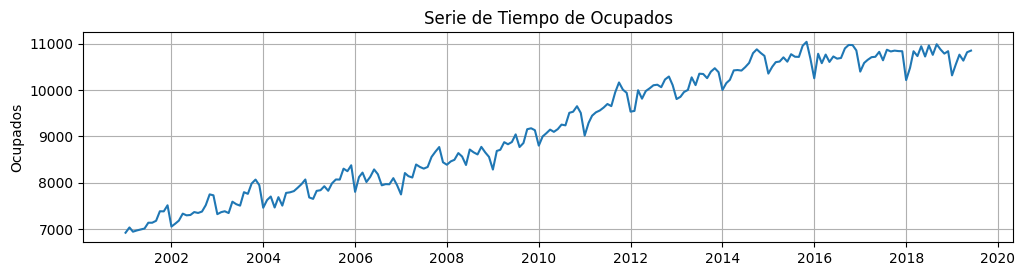

In [365]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de Tiempo de Ocupados")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

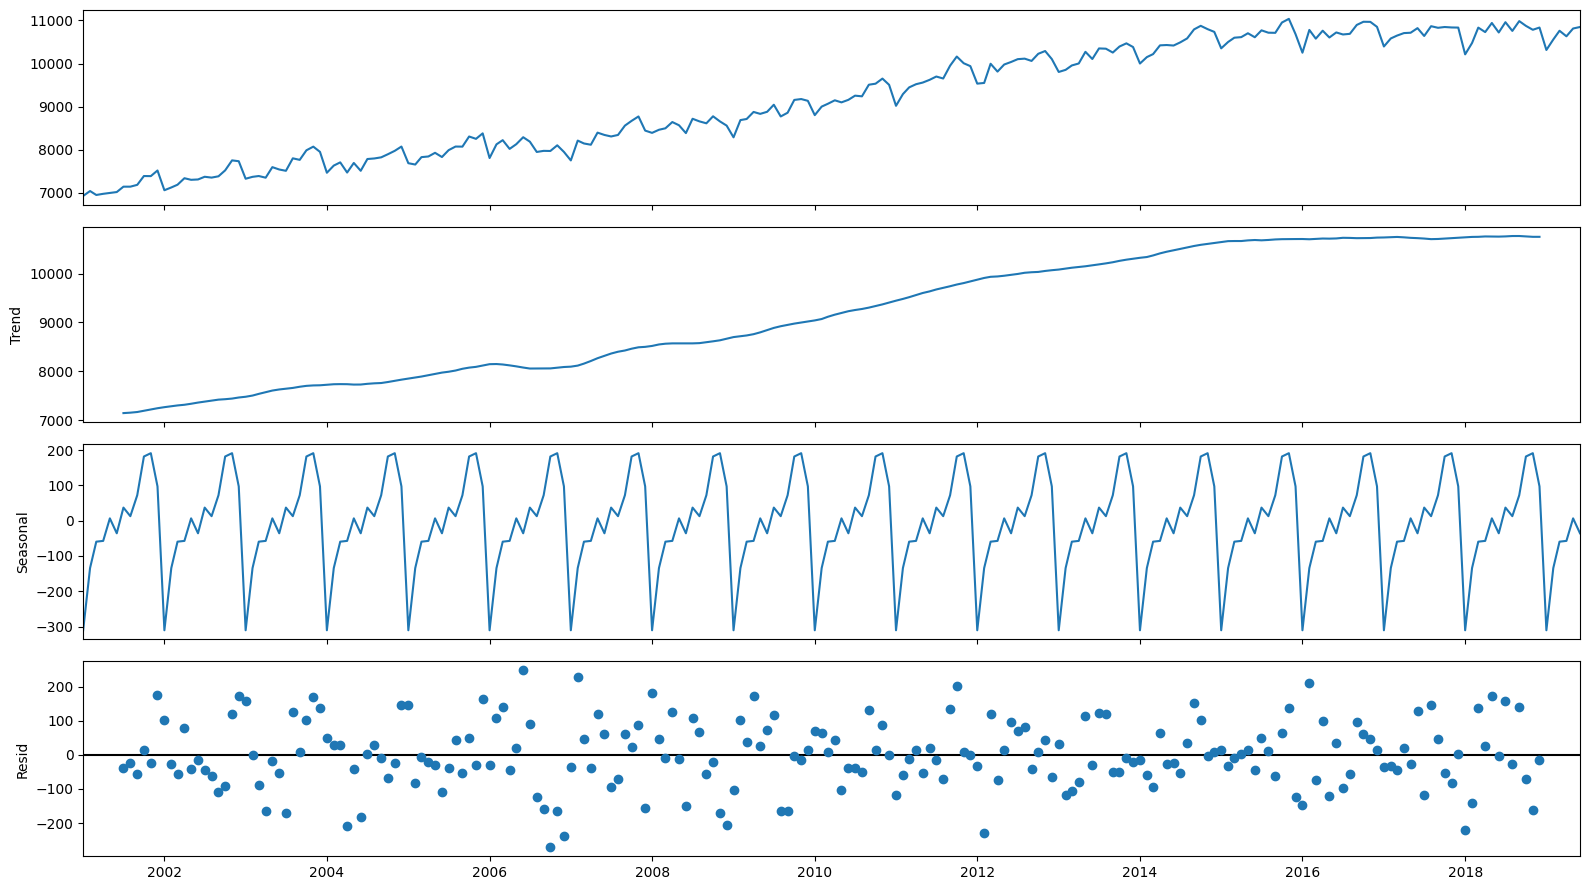

In [366]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### **3. Autocorrelación**

Para determinar si existe autocorrelación usamos la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [367]:
signo = data.Ocupados>0

In [368]:
signo.value_counts()

,count
Ocupados,
True,222


In [369]:
runstest_1samp(signo, correction=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/sandbox/stats/runs.py:102: RuntimeWarning: invalid value encountered in scalar divide
  z /= rstd


(np.float64(nan), np.float64(nan))

In [370]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(data.Ocupados, lags=[1], return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,215.466151,8.818153e-49,212.580444,3.757527e-48


Hay autocorrelación para el primer rezago.




In [371]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.Ocupados, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas. Se puede concluir que la Si presenta autocorrelación.

### **4. Tendencia Lineal**

In [372]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.02e-150
Time:                        02:24:54   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

In [373]:
y_real_6 = data["Ocupados"].iloc[-6:].values
y_pred_6 = preds["Point_forecast"].values

rmse_6 = np.sqrt(mean_squared_error(y_real_6, y_pred_6))
print(f"RMSE de los últimos 6 meses: {rmse_6:.4f}")

rmse_pct = (rmse_6 / np.mean(y_real_6)) * 100
print(f"Error relativo promedio: {rmse_pct:.2f}%")

RMSE de los últimos 6 meses: 634.7543
Error relativo promedio: 5.96%


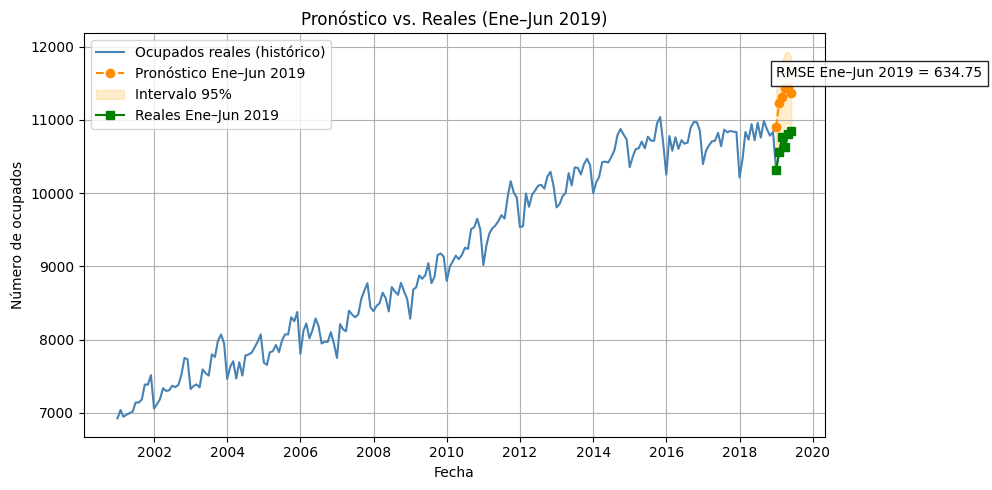

In [374]:
h = len(preds)
target_idx = pd.date_range('2019-01-01', periods=h, freq='MS')
preds = preds.copy()
preds.index = target_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds.loc['2019-01':'2019-06', 'Point_forecast']

plt.figure(figsize=(10,5))
plt.plot(data.index, data['Ocupados'], label='Ocupados reales (histórico)', color='steelblue')
plt.plot(preds.index, preds['Point_forecast'], '--o', color='darkorange', label='Pronóstico Ene–Jun 2019')

if {'lower_95','upper_95'}.issubset(preds.columns):
    plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], alpha=0.2, color='orange', label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values, 'gs-', label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), getattr(preds['upper_95'], 'max', preds['Point_forecast'].max)())
plt.text(preds.index[0], y_top*0.97, f"RMSE Ene–Jun 2019 = {rmse_6:.2f}",
         bbox=dict(facecolor='white', alpha=0.85))

plt.title('Pronóstico vs. Reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

                Real  Predicho   Error  |Error|  % Error
2019-01-01  10314.44  10899.31 -584.87   584.87    -5.67
2019-02-01  10557.92  11234.99 -677.07   677.07    -6.41
2019-03-01  10760.78  11307.02 -546.25   546.25    -5.08
2019-04-01  10632.03  11429.65 -797.62   797.62    -7.50
2019-05-01  10813.00  11452.09 -639.09   639.09    -5.91
2019-06-01  10848.00  11371.40 -523.40   523.40    -4.82


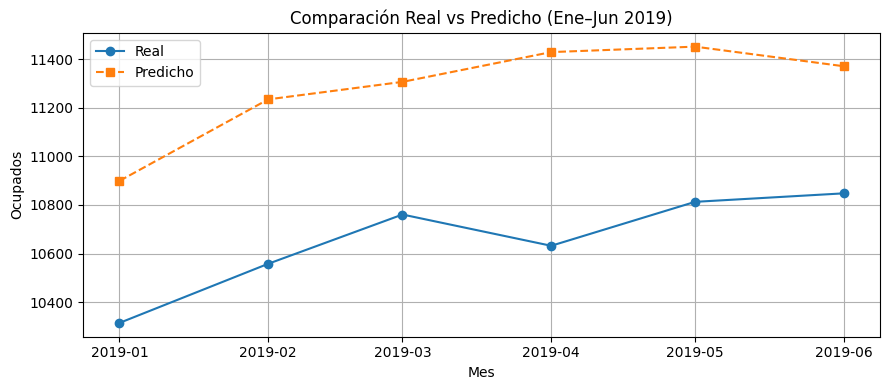

In [375]:
target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

y_real = data.loc[target_idx, 'Ocupados']
y_pred = preds.loc[target_idx, 'Point_forecast']

cmp = pd.DataFrame({
    'Real': y_real,
    'Predicho': y_pred
}, index=common)

cmp['Error'] = cmp['Real'] - cmp['Predicho']
cmp['|Error|'] = cmp['Error'].abs()
cmp['% Error'] = 100 * cmp['Error'] / cmp['Real']

print(cmp.round(2))

plt.figure(figsize=(9,4))
plt.plot(cmp.index, cmp['Real'], marker='o', label='Real')
plt.plot(cmp.index, cmp['Predicho'], marker='s', linestyle='--', label='Predicho')
plt.title('Comparación Real vs Predicho (Ene–Jun 2019)')
plt.xlabel('Mes'); plt.ylabel('Ocupados'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

### **5. Tendencia Cuadratica**

In [376]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2560.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          1.33e-152
Time:                        02:24:55   Log-Likelihood:                -1551.0
No. Observations:                 222   AIC:                             3108.
Df Residuals:                     219   BIC:                             3118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6790.8804     53.552    126.810      0.0

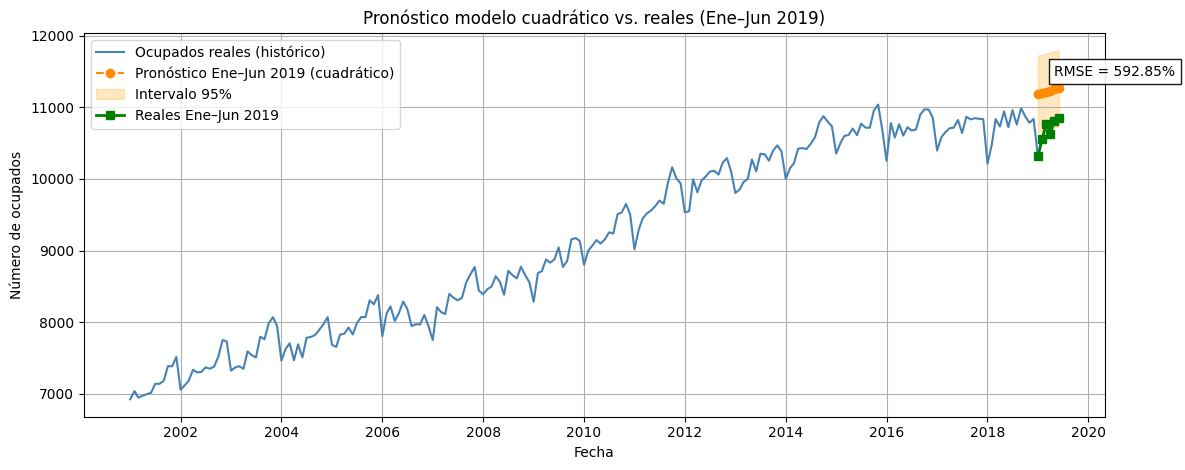


Comparación Ene–Jun 2019 (modelo cuadrático):
                Real  Predicho  lower_95  upper_95   Error  |Error|  % Error
2019-01-01  10314.44  11187.59  10657.51  11717.67 -873.15   873.15    -8.47
2019-02-01  10557.92  11202.69  10672.23  11733.16 -644.77   644.77    -6.11
2019-03-01  10760.78  11217.75  10686.89  11748.61 -456.97   456.97    -4.25
2019-04-01  10632.03  11232.77  10701.50  11764.03 -600.74   600.74    -5.65
2019-05-01  10813.00  11247.74  10716.05  11779.43 -434.74   434.74    -4.02
2019-06-01  10848.00  11262.67  10730.56  11794.79 -414.67   414.67    -3.82

RMSE (cuadrático): 592.85


In [381]:
h = 6
x_for = np.linspace(data.shape[0] + 1, data.shape[0] + h, h)
x_for_quad = np.column_stack((x_for, x_for**2))
X_for = sm.add_constant(x_for_quad)

dt_q = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)

preds_q = dt_q[['mean', 'obs_ci_lower', 'obs_ci_upper']].copy()
preds_q.columns = ['Point_forecast', 'lower_95', 'upper_95']

target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')
preds_q.index = target_idx

y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds_q.loc['2019-01':'2019-06', 'Point_forecast']

common = y_real_6.index.intersection(y_pred_6.index)
y_real_6 = y_real_6.loc[common]
y_pred_6 = y_pred_6.loc[common]

rmse_q = np.sqrt(mean_squared_error(y_real_6, y_pred_6))
mape_q = (np.abs((y_real_6 - y_pred_6) / y_real_6).mean()) * 100

plt.figure(figsize=(12,4.8))

plt.plot(data.index, data['Ocupados'],
         color='steelblue', label='Ocupados reales (histórico)')

plt.plot(preds_q.index, preds_q['Point_forecast'],
         '--o', color='darkorange', label='Pronóstico Ene–Jun 2019 (cuadrático)')

plt.fill_between(preds_q.index, preds_q['lower_95'], preds_q['upper_95'],
                 color='orange', alpha=0.25, label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values,
         'gs-', linewidth=2, label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), preds_q['upper_95'].max())
plt.text(preds_q.index[-2], y_top*0.97,
         f"RMSE = {rmse_q:.2f}%",
         fontsize=10, bbox=dict(facecolor='white', alpha=0.9))

plt.title('Pronóstico modelo cuadrático vs. reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(loc='upper left'); plt.grid(True); plt.tight_layout()
plt.show()

cmp_q = pd.DataFrame({
    'Real': y_real_6,
    'Predicho': y_pred_6,
    'lower_95': preds_q.loc[common, 'lower_95'],
    'upper_95': preds_q.loc[common, 'upper_95']
})
cmp_q['Error']   = cmp_q['Real'] - cmp_q['Predicho']
cmp_q['|Error|'] = cmp_q['Error'].abs()
cmp_q['% Error'] = 100 * cmp_q['Error'] / cmp_q['Real']
print('\nComparación Ene–Jun 2019 (modelo cuadrático):')
print(cmp_q.round(2))
print(f"\nRMSE (cuadrático): {rmse_q:.2f}")

### **4. Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [ ]:
sm.stats.acorr_ljungbox((data.Ocupados-data.Ocupados.mean())**2, lags=range(1,21), return_df=True,boxpierce=True)

### **5. Normalidad**


In [ ]:
sm.qqplot(data.Ocupados, line ='45')
py.show()

In [ ]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data.Ocupados)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data.Ocupados), max(data.Ocupados), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data.Ocupados, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data.Ocupados, np.full_like(data.Ocupados, 0.000), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [ ]:
stats.shapiro(data.Ocupados)

In [ ]:
stats.jarque_bera(data.Ocupados)

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **8. Estimación de la Estacionalidad**

In [382]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2687
Date:                Sun, 09 Nov 2025   Prob (F-statistic):              0.991
Time:                        02:27:32   Log-Likelihood:                -1903.9
No. Observations:                 222   AIC:                             3832.
Df Residuals:                     210   BIC:                             3873.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    302.768     29.092      0.0

In [383]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=6, freq='MS')

# Create month dummies for the future dates, ensuring all months are represented
x_for = pd.get_dummies(range_dates.month, dtype=float)
# Add a constant term
x_for = sm.add_constant(x_for, has_constant='add')

# Reindex the future month dummies to match the columns of the original training data
# This ensures that all month columns are present, even if a month is not in the future range
# and that the constant is in the correct position.
X_for = x_for.reindex(columns=X.columns, fill_value=0)

In [ ]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **9. Tendencia + Estacionalidad**

In [ ]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())